In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-delay-and-cancellation-dataset-2019-2023/flights_sample_3m.csv
/kaggle/input/flight-delay-and-cancellation-dataset-2019-2023/dictionary.html


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE                  object 
 2   AIRLINE_DOT              object 
 3   AIRLINE_CODE             object 
 4   DOT_CODE                 int64  
 5   FL_NUMBER                int64  
 6   ORIGIN                   object 
 7   ORIGIN_CITY              object 
 8   DEST                     object 
 9   DEST_CITY                object 
 10  CRS_DEP_TIME             int64  
 11  DEP_TIME                 float64
 12  DEP_DELAY                float64
 13  TAXI_OUT                 float64
 14  WHEELS_OFF               float64
 15  WHEELS_ON                float64
 16  TAXI_IN                  float64
 17  CRS_ARR_TIME             int64  
 18  ARR_TIME                 float64
 19  ARR_DELAY                float64
 20  CANCELLED                float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


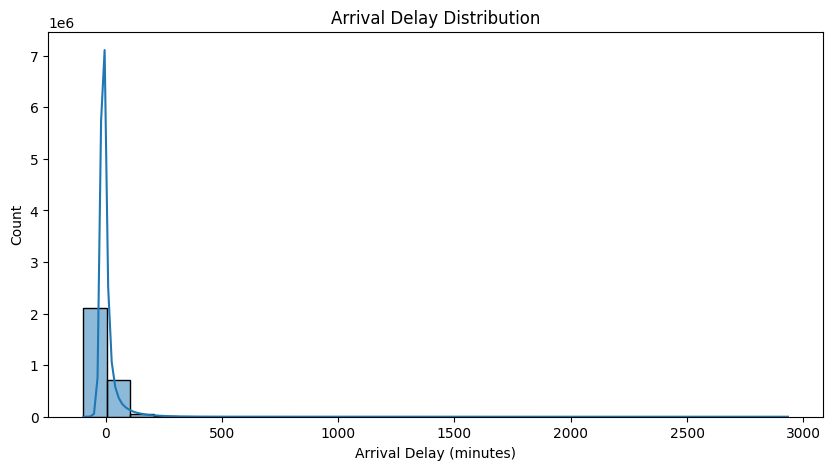

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


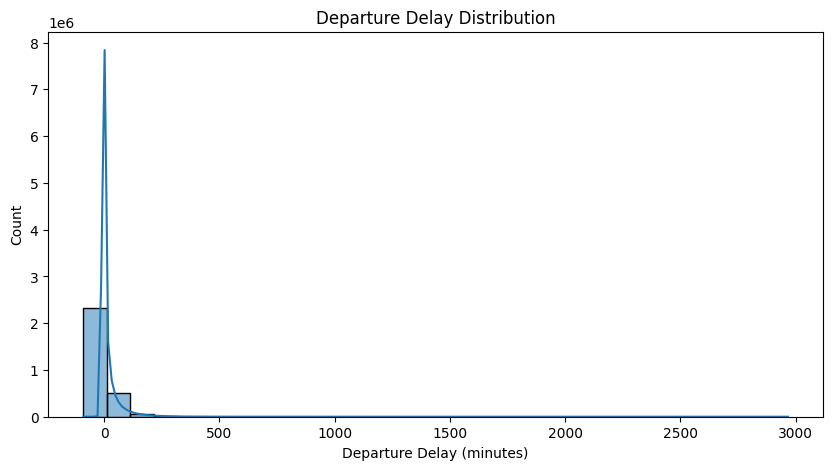

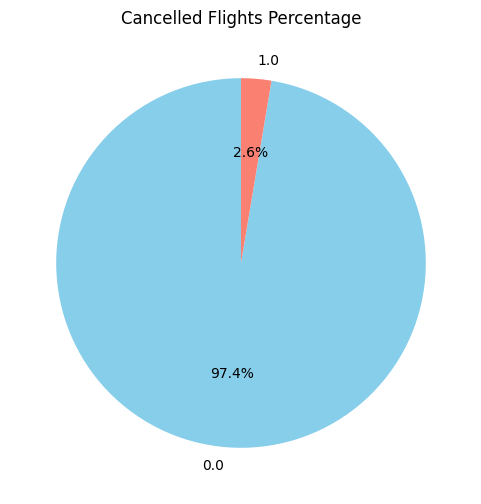

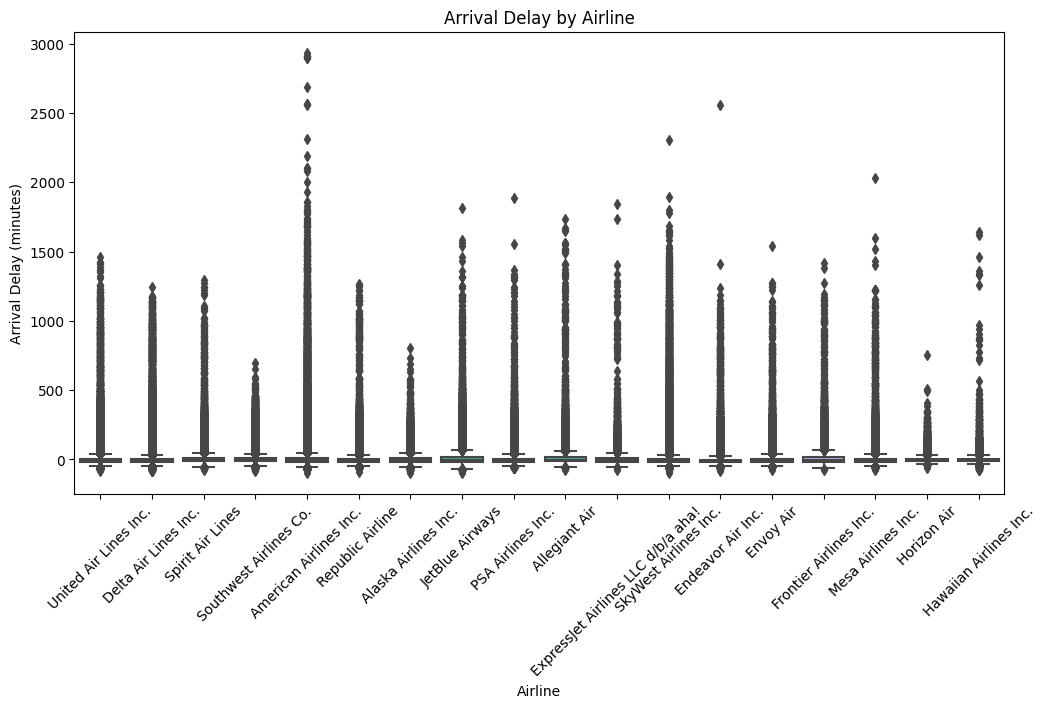

ValueError: Could not interpret input 'MONTH'

<Figure size 1200x600 with 0 Axes>

In [5]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("AirlineEDA").getOrCreate()

# Load the dataset
file_path = "/kaggle/input/flight-delay-and-cancellation-dataset-2019-2023/flights_sample_3m.csv"  # Replace with the actual filename
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Basic Info
print("Dataset Schema:")
df_spark.printSchema()
print("\nFirst 5 Rows:")
df_spark.show(5)

# Check for missing values
print("\nMissing Values:")
missing_values = df_spark.select([(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns]).agg(*[sum(col(c)).alias(c) for c in df_spark.columns])
missing_values.show()

# Convert 'FL_DATE' to month for monthly analysis
df_spark = df_spark.withColumn("MONTH", month("FL_DATE"))

# Convert Spark DataFrame to Pandas for plotting
df = df_spark.toPandas()

# Distribution of Arrival and Departure Delays
plt.figure(figsize=(10, 5))
sns.histplot(df['ARR_DELAY'], bins=30, kde=True)
plt.title("Arrival Delay Distribution")
plt.xlabel("Arrival Delay (minutes)")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['DEP_DELAY'], bins=30, kde=True)
plt.title("Departure Delay Distribution")
plt.xlabel("Departure Delay (minutes)")
plt.show()

# Cancelled flights analysis
cancelled = df['CANCELLED'].value_counts(normalize=True)
plt.figure(figsize=(6, 6))
cancelled.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title("Cancelled Flights Percentage")
plt.ylabel("")
plt.show()

# Delay by Airline
plt.figure(figsize=(12, 6))
sns.boxplot(x='AIRLINE', y='ARR_DELAY', data=df)
plt.title("Arrival Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Arrival Delay (minutes)")
plt.xticks(rotation=45)
plt.show()

# Delay by Month
plt.figure(figsize=(12, 6))
sns.boxplot(x='MONTH', y='ARR_DELAY', data=df)
plt.title("Arrival Delay by Month")
plt.xlabel("Month")
plt.ylabel("Arrival Delay (minutes)")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Stop the Spark session
spark.stop()
